In [22]:
import pandas as pd
import json

pd.set_option('display.max_columns', 500)

MARKET = "base_cbbtc_usdc_full"
MARKET = "eth_cbbtc_usdc"

df = pd.read_csv(
    f"/Users/yegortrussov/Documents/ml/lending_protocols/dataset_collection/data/markets_enriched/{MARKET}.csv"
)
with open("/Users/yegortrussov/Documents/ml/lending_protocols/dataset_collection/data/common/markets_meta.json", 'r') as f:
    markets_meta = json.load(f)
with open("/Users/yegortrussov/Documents/ml/lending_protocols/dataset_collection/data/common/assets_meta.json", 'r') as f:
    assets_meta = json.load(f)
market_addr = df["market_address"].unique()[0]
market_meta = markets_meta[market_addr]
asset_meta = assets_meta[market_meta["collateral_asset_address"]]

df.columns

Index(['hash', 'type', 'timestamp', 'user_address', 'assets', 'assets_usd',
       'liquidated_assets', 'liquidated_assets_usd', 'market', 'datetime',
       'market_address', 'total_supply_before', 'total_borrow_before',
       'total_supply_after', 'total_borrow_after', 'utilization_before',
       'utilization_after', 'tx_actions', 'borrow_rate_before',
       'supply_rate_before', 'borrow_rate_after', 'supply_rate_after',
       'collateral_price', 'loan_asset_price', 'collateral_before',
       'collateral_value_before', 'debt_before', 'ltv_before',
       'collateral_after', 'collateral_value_after', 'debt_after', 'ltv_after',
       'health_factor_before', 'health_factor_after', 'event_type',
       'vault_flg', 'volatility_1h', 'drawdown_1h', 'trend_1h',
       'volatility_6h', 'drawdown_6h', 'trend_6h', 'volatility_24h',
       'drawdown_24h', 'trend_24h'],
      dtype='object')

In [9]:
asset_meta

{'asset_assress': '0xcbB7C0000aB88B473b1f5aFd9ef808440eed33Bf',
 'decimals': 8,
 'symbol': 'cbBTC',
 'historical_price': [[1704272400, None],
  [1704276000, None],
  [1704279600, None],
  [1704283200, None],
  [1704286800, None],
  [1704290400, None],
  [1704294000, None],
  [1704297600, None],
  [1704301200, None],
  [1704304800, None],
  [1704308400, None],
  [1704312000, None],
  [1704315600, None],
  [1704319200, None],
  [1704322800, None],
  [1704326400, None],
  [1704330000, None],
  [1704333600, None],
  [1704337200, None],
  [1704340800, None],
  [1704344400, None],
  [1704348000, None],
  [1704351600, None],
  [1704355200, None],
  [1704358800, None],
  [1704362400, None],
  [1704366000, None],
  [1704369600, None],
  [1704373200, None],
  [1704376800, None],
  [1704380400, None],
  [1704384000, None],
  [1704387600, None],
  [1704391200, None],
  [1704394800, None],
  [1704398400, None],
  [1704402000, None],
  [1704405600, None],
  [1704409200, None],
  [1704412800, None],


In [23]:
df.head(1).to_dict()
from tqdm.auto import tqdm
import numpy as np
def create_market_hourly_dataset(df, asset_meta):
    # Generate hourly timestamps
    min_time = df['timestamp'].min()
    max_time = df['timestamp'].max()
    
    start_hour = (min_time // 3600) * 3600
    end_hour = ((max_time // 3600) + 1) * 3600
    
    hourly_ts = np.arange(start_hour, end_hour + 3600, 3600)
    
    # Sort events
    df_sorted = df.sort_values('timestamp')
    events_ts = df_sorted['timestamp'].values
    
    # Find last event index for each hour using searchsorted
    idx = np.searchsorted(events_ts, hourly_ts, side='right') - 1
    
    # Extract values
    result_data = []
    for i, hour_ts in tqdm(enumerate(hourly_ts)):
        if idx[i] >= 0:
            last_row = df_sorted.iloc[idx[i]]
            row_data = {
                'timestamp': hour_ts,
                'datetime': pd.to_datetime(hour_ts, unit='s'),
                'total_supply': last_row['total_supply_after'],
                'total_borrow': last_row['total_borrow_after'],
                'utilization': last_row['utilization_after'],
                'borrow_rate': last_row['borrow_rate_after'],
                'supply_rate': last_row['supply_rate_after'],
                'volatility_6h': last_row.get('volatility_6h', 0),
                'drawdown_6h': last_row.get('drawdown_6h', 0),
                'collateral_price': last_row.get('collateral_price', 0),
                'loan_asset_price': last_row.get('loan_asset_price', 0),
                'avg_health_factor': last_row.get('health_factor_after', 0)
            }
        else:
            row_data = {
                'timestamp': hour_ts,
                'datetime': pd.to_datetime(hour_ts, unit='s'),
                'total_supply': 0,
                'total_borrow': 0,
                'utilization': 0,
                'borrow_rate': 0,
                'supply_rate': 0,
                'volatility_6h': 0,
                'drawdown_6h': 0,
                'collateral_price': 0,
                'loan_asset_price': 0,
                'avg_health_factor': 0
            }
        result_data.append(row_data)
    
    result_df = pd.DataFrame(result_data)
    
    # Forward fill
    result_df = result_df.ffill().fillna(0)
    
    # Add asset price
    if 'historical_price' in asset_meta and asset_meta['historical_price']:
        price_df = pd.DataFrame(asset_meta['historical_price'], columns=['timestamp', 'price'])
        price_df = price_df.dropna()
        if not price_df.empty:
            result_df = result_df.merge(price_df, on='timestamp', how='left')
            result_df['asset_price'] = result_df['price'].ffill().fillna(0)
            result_df = result_df.drop(columns=['price'])
    
    return result_df
hourly_df = create_market_hourly_dataset(
    df,
    asset_meta,
)

0it [00:00, ?it/s]

<Axes: >

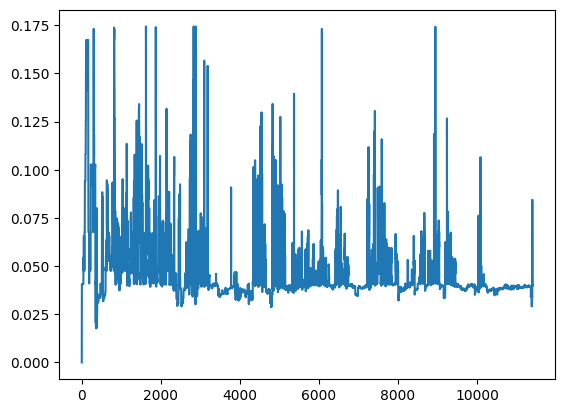

In [24]:
hourly_df["borrow_rate"].plot()
# hourly_df["total_supply"].plot()

In [27]:
hourly_df["borrow_rate"]
# hourly_df.head(2)

df[df["datetime"]>"2025-12-01"]["borrow_rate_after"]

43756    0.038739
43757    0.038739
43758    0.038741
43759    0.038741
43760    0.038740
           ...   
53756    0.040014
53757    0.040014
53758    0.040014
53759    0.040014
53760    0.040014
Name: borrow_rate_after, Length: 10005, dtype: float64

In [29]:
hourly_df.to_csv(f"/Users/yegortrussov/Documents/ml/lending_protocols/dataset_collection/data/markets_hourly_data/{MARKET}.csv",index=False)
